# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/13_WvGllSbdMF2DAgaFHBEbOH7iEepP6n?usp=sharing

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
)

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#load data
transform = transforms.Compose([transforms.Resize((224, 224)),
              transforms.ToTensor()])
data_path = "/content/gdrive/MyDrive/Colab Notebooks/APS360 LAB/lab3/Lab3_Gestures_Summer"
dataset = torchvision.datasets.ImageFolder(data_path, transform = transform)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                            shuffle=True)
train_size = int(0.65 * len(dataset))
val_size = int(0.17 * len(dataset))
test_size = int(0.17 * len(dataset))
overfit_size = len(dataset) - train_size - val_size - test_size

train_dataset, val_dataset, test_dataset, overfit_dataset= torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size, overfit_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1,
                                           num_workers=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1,
                                           num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                           num_workers=1, shuffle=True)
overfit_loader = torch.utils.data.DataLoader(overfit_dataset, batch_size=1,
                                           num_workers=1, shuffle=True)

In [ ]:
print('There are',len(train_loader),
      'training images, which is {:.2f} % of the entire dataset.'.format(len(train_loader)/len(data_loader) * 100))
print('There are',len(val_loader),
      'validation images, which is {:.2f} % of the entire dataset.'.format(len(val_loader)/len(data_loader) * 100))
print('There are',len(test_loader),
      'test images, which is {:.2f} % of the entire dataset.'.format(len(test_loader)/len(data_loader) * 100))

#I used torch.utils.data.DataLoader for loading data,
#and torch.utils.data.random_split for splitting data.
#The splitting strategy are as shown in the code, where
#I put 65% of the dataset for training, 17% for validation,
#17% for testing, and a very small portion for model sanity check.

There are 1442 training images, which is 64.98 % of the entire dataset.
There are 377 validation images, which is 16.99 % of the entire dataset.
There are 377 test images, which is 16.99 % of the entire dataset.


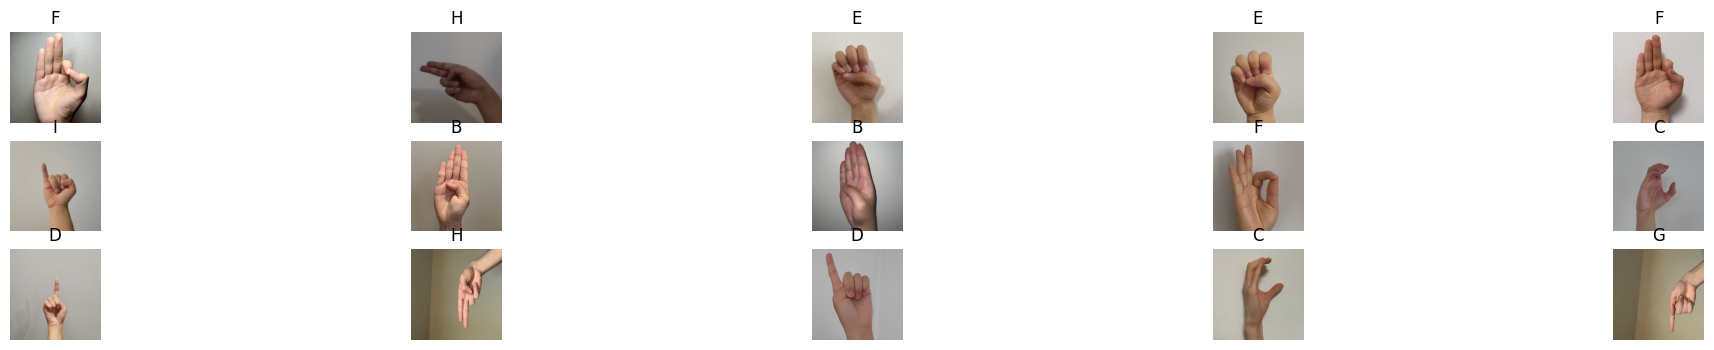

In [ ]:
#visualizing sample data
k = 0
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
fig = plt.figure(figsize=(25, 4))

for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    label = labels[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1, 2, 0])
    # normalize pixel intensity values to [0, 1]
    img = img

    # Display the image
    ax = fig.add_subplot(3, 5, k+1)
    ax.axis('off')
    ax.imshow(img)
    ax.set_title(classes[label])  # Use label index to get the corresponding class

    k += 1
    if k >= 15:
        break

### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [ ]:
class GestRec(nn.Module):
    def __init__(self):
        super(GestRec, self).__init__()
        self.name = "GestRec"
        self.conv1 = nn.Conv2d(3, 5, 5) #in channels, #out channels, #kernal size
        self.pool = nn.MaxPool2d(2, 2) #kernal size, stride
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 53 * 53, 32) #input size, output size
        self.fc2 = nn.Linear(32, 9) #input size, output size

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

model = GestRec()

**Answer: I choose an CNNs Model with 2 convolution layers, 2 pooling layers, and 2 fully-connected layers. By using two convolution layers, the model is able to learn and capture both low-level and high-level features of the hand gestures. Pooling helps reduce dimension of the feature map, allowing the model to be trained faster. The 2 fully-connected layers are used for classification in the end. ReLu activation function is utilized in multiple steps in the model so that the model can learn non-linearity.**

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                  epoch)
    return path

def get_accuracy(model, batch_size, train=False):
    if train:
        data = train_dataset
    else:
        data = val_dataset

    correct = 0
    total = 0

    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        #############################################

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train(model, train_data, batch_size=64, learning_rate =0.001, num_epochs=30):
    torch.manual_seed(1000)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    start_time = time.time()
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
          # Loop over each batch of images and labels
          #############################################
          # To Enable GPU Usage
          if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

          #############################################

          out = model(imgs)             # forward pass
          loss = criterion(out, labels) # compute the total loss
          loss.backward()               # backward pass (compute parameter updates)
          optimizer.step()              # make the updates for each parameter
          optimizer.zero_grad()         # a clean-up step for PyTorch

          # save the current training information
          iters.append(n)
          losses.append(float(loss) / batch_size)             # compute *average* loss
          n += 1

          # Save the current model (checkpoint) to a file
          model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
          torch.save(model.state_dict(), model_path)

        train_acc.append(get_accuracy(model, batch_size, train=True))   # compute training accuracy
        val_acc.append(get_accuracy(model, batch_size, train=False))    #compute validation accuracy
        print(("Epoch {}: Train accuracy: {} |" +
                "Validation accuracy: {} ").format(
              epoch +1,
              train_acc[epoch],
              val_acc[epoch]))

    print("Finish Training")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(range(num_epochs+1), train_acc, label="Train")
    plt.plot(range(num_epochs+1), val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

**Answer:**

**For loss function, I chose the Cross-Entropy loss function, which is optimal for multi-class classification training. The optimizer I chose is the Stochastic Gradient Descent optimizer because it is suited for large-scale datasets, and it updates on a randomly selected subset of training examples at each iteration. This optimizer is computationally-efficient.**

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                  epoch)
    return path

def get_accuracy_overfit(model, batch_size = 23):

    data = overfit_dataset

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):


        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        #############################################


        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train_overfit(model, data, batch_size=23, learning_rate =0.001, num_epochs=200):

    torch.manual_seed(1000)
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle = True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9)

    iters, losses, train_acc = [], [], []

    # training
    start_time = time.time()
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
          # Loop over each batch of images and labels
          #############################################

          # To Enable GPU Usage
          if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

          #############################################

          out = model(imgs)             # forward pass
          loss = criterion(out, labels) # compute the total loss
          loss.backward()               # backward pass (compute parameter updates)
          optimizer.step()              # make the updates for each parameter
          optimizer.zero_grad()         # a clean-up step for PyTorch

          # save the current training information
          iters.append(n)
          losses.append(float(loss) / batch_size)             # compute *average* loss
          train_acc.append(get_accuracy_overfit(model, batch_size))   # compute training accuracy
          n += 1

          # Save the current model (checkpoint) to a file
          model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
          torch.save(model.state_dict(), model_path)

        print(("Epoch {}: Train accuracy: {}").format(
            epoch + 1,
            train_acc[epoch]))

        if(get_accuracy_overfit(model, batch_size) == 1):
            break

    print("Finish Training")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))

CUDA is available!  Training on GPU ...
Epoch 1: Train accuracy: 0.13043478260869565
Epoch 2: Train accuracy: 0.21739130434782608
Epoch 3: Train accuracy: 0.2608695652173913
Epoch 4: Train accuracy: 0.2608695652173913
Epoch 5: Train accuracy: 0.2608695652173913
Epoch 6: Train accuracy: 0.2608695652173913
Epoch 7: Train accuracy: 0.2608695652173913
Epoch 8: Train accuracy: 0.2608695652173913
Epoch 9: Train accuracy: 0.2608695652173913
Epoch 10: Train accuracy: 0.2608695652173913
Epoch 11: Train accuracy: 0.2608695652173913
Epoch 12: Train accuracy: 0.2608695652173913
Epoch 13: Train accuracy: 0.2608695652173913
Epoch 14: Train accuracy: 0.2608695652173913
Epoch 15: Train accuracy: 0.2608695652173913
Epoch 16: Train accuracy: 0.2608695652173913
Epoch 17: Train accuracy: 0.2608695652173913
Epoch 18: Train accuracy: 0.2608695652173913
Epoch 19: Train accuracy: 0.2608695652173913
Epoch 20: Train accuracy: 0.2608695652173913
Epoch 21: Train accuracy: 0.2608695652173913
Epoch 22: Train accura

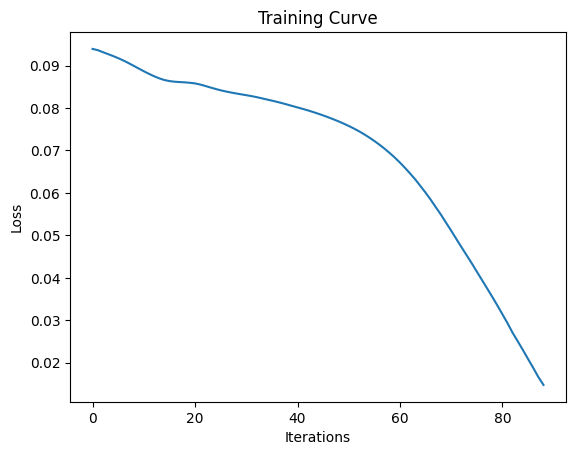

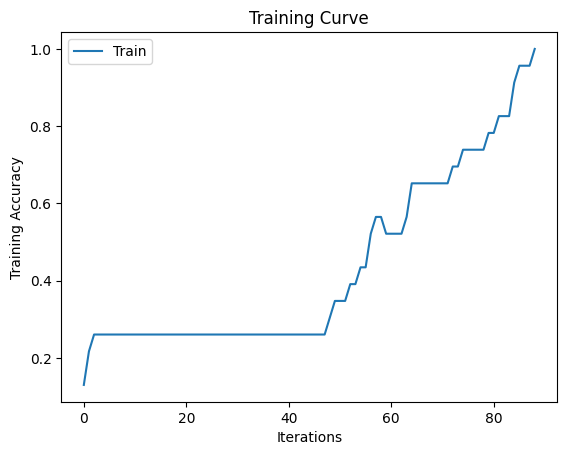

Final Training Accuracy: 1.0


In [ ]:
use_cuda = True

model = GestRec()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#proper model

train_overfit(model, overfit_dataset,
      batch_size = 23, num_epochs = 120)

### 3. Hyperparameter Search [10 pt]

### Part (a) - 1 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

In [ ]:
#The three hyperparameters that
#I think most worth tuning is:
  #1. Batch_size
  #2. padding/stride
  #3. number of hidden layers/output channels

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

CUDA is available!  Training on GPU ...
Epoch 1: Train accuracy: 0.11719833564493759 |Validation accuracy: 0.09814323607427056 
Epoch 2: Train accuracy: 0.11719833564493759 |Validation accuracy: 0.10610079575596817 
Epoch 3: Train accuracy: 0.20180305131761442 |Validation accuracy: 0.1724137931034483 
Epoch 4: Train accuracy: 0.1289875173370319 |Validation accuracy: 0.11405835543766578 
Epoch 5: Train accuracy: 0.18862690707350901 |Validation accuracy: 0.16445623342175067 
Epoch 6: Train accuracy: 0.18307905686546463 |Validation accuracy: 0.16445623342175067 
Epoch 7: Train accuracy: 0.21497919556171982 |Validation accuracy: 0.1883289124668435 
Epoch 8: Train accuracy: 0.22330097087378642 |Validation accuracy: 0.20689655172413793 
Epoch 9: Train accuracy: 0.24965325936199723 |Validation accuracy: 0.2440318302387268 
Epoch 10: Train accuracy: 0.30235783633841884 |Validation accuracy: 0.2917771883289125 
Epoch 11: Train accuracy: 0.4160887656033287 |Validation accuracy: 0.392572944297082

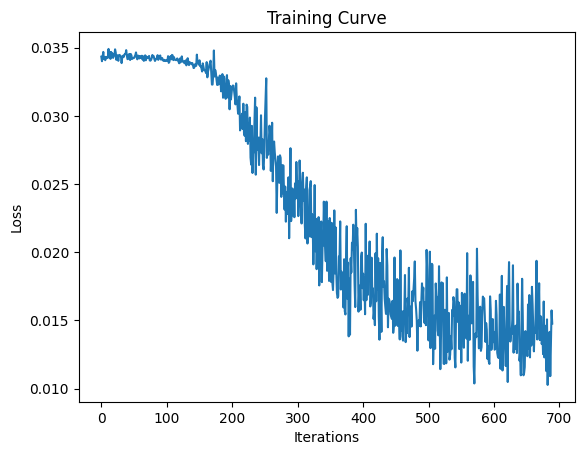

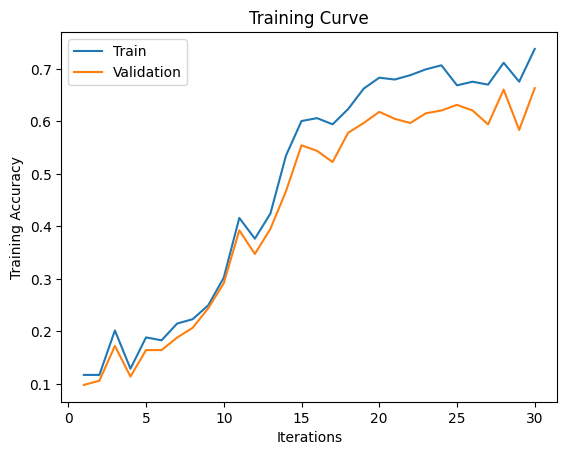

Final Training Accuracy: 0.7378640776699029
Final Validation Accuracy: 0.6631299734748011


In [ ]:
use_cuda = True

model = GestRec()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model, train_dataset)

In [ ]:
class GestRec_mod1(nn.Module):
    def __init__(self):
        super(GestRec_mod1, self).__init__()
        self.name = "GestRec_mod1"
        self.conv1 = nn.Conv2d(3, 5, 5, padding = 1) #in channels, #out channels, #kernal size
        self.pool = nn.MaxPool2d(2, 2) #kernal size, stride
        self.conv2 = nn.Conv2d(5, 10, 5, padding = 1)
        self.fc1 = nn.Linear(10 * 54 * 54, 35) #input size, output size
        self.fc2 = nn.Linear(35, 9) #input size, output size

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 54 * 54)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

model_1 = GestRec_mod1()

CUDA is available!  Training on GPU ...
Epoch 1: Train accuracy: 0.11858529819694869 |Validation accuracy: 0.11405835543766578 
Epoch 2: Train accuracy: 0.11858529819694869 |Validation accuracy: 0.11405835543766578 
Epoch 3: Train accuracy: 0.12274618585298197 |Validation accuracy: 0.10344827586206896 
Epoch 4: Train accuracy: 0.16574202496532595 |Validation accuracy: 0.14058355437665782 
Epoch 5: Train accuracy: 0.12413314840499307 |Validation accuracy: 0.10875331564986737 
Epoch 6: Train accuracy: 0.1650485436893204 |Validation accuracy: 0.13262599469496023 
Epoch 7: Train accuracy: 0.19764216366158113 |Validation accuracy: 0.16976127320954906 
Epoch 8: Train accuracy: 0.2565880721220527 |Validation accuracy: 0.2440318302387268 
Epoch 9: Train accuracy: 0.24895977808599168 |Validation accuracy: 0.246684350132626 
Epoch 10: Train accuracy: 0.2538141470180305 |Validation accuracy: 0.2440318302387268 
Epoch 11: Train accuracy: 0.25866851595006934 |Validation accuracy: 0.2679045092838196

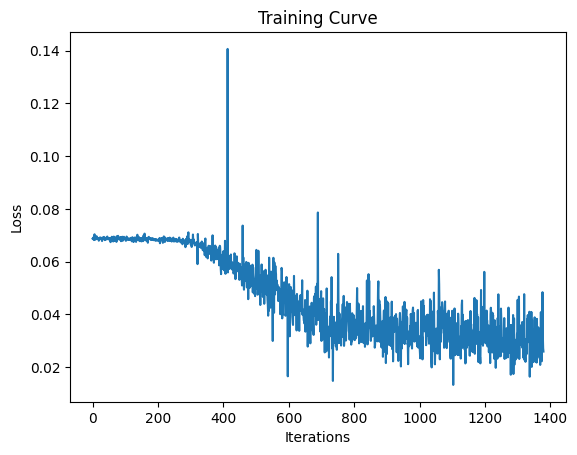

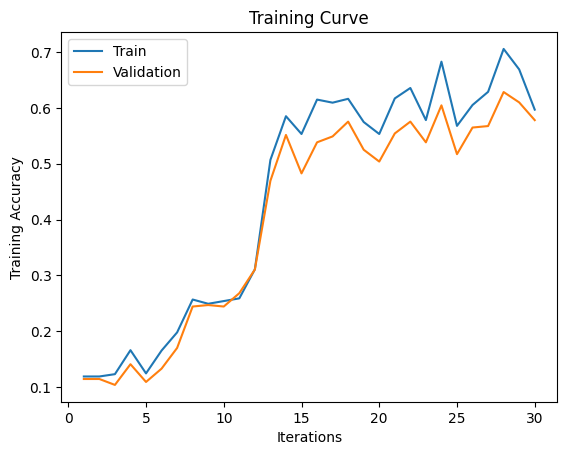

Final Training Accuracy: 0.5970873786407767
Final Validation Accuracy: 0.5782493368700266


In [ ]:
#changing network architechture and batch_size

use_cuda = True

model_1 = GestRec_mod1()

if use_cuda and torch.cuda.is_available():
  model_1.cuda()

  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#proper model

train(model_1, train_dataset, batch_size = 32)

CUDA is available!  Training on GPU ...
Epoch 1: Train accuracy: 0.19902912621359223 |Validation accuracy: 0.15649867374005305 
Epoch 2: Train accuracy: 0.21705963938973646 |Validation accuracy: 0.17771883289124668 
Epoch 3: Train accuracy: 0.20804438280166435 |Validation accuracy: 0.16180371352785147 
Epoch 4: Train accuracy: 0.16851595006934814 |Validation accuracy: 0.14854111405835543 
Epoch 5: Train accuracy: 0.21636615811373092 |Validation accuracy: 0.1830238726790451 
Epoch 6: Train accuracy: 0.26629680998613037 |Validation accuracy: 0.23076923076923078 
Epoch 7: Train accuracy: 0.3002773925104022 |Validation accuracy: 0.23342175066312998 
Epoch 8: Train accuracy: 0.36893203883495146 |Validation accuracy: 0.3952254641909814 
Epoch 9: Train accuracy: 0.3737864077669903 |Validation accuracy: 0.3793103448275862 
Epoch 10: Train accuracy: 0.4431345353675451 |Validation accuracy: 0.4244031830238727 
Epoch 11: Train accuracy: 0.42302357836338417 |Validation accuracy: 0.4164456233421750

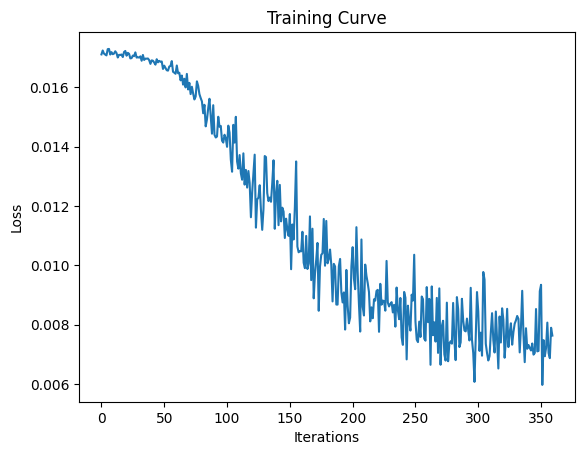

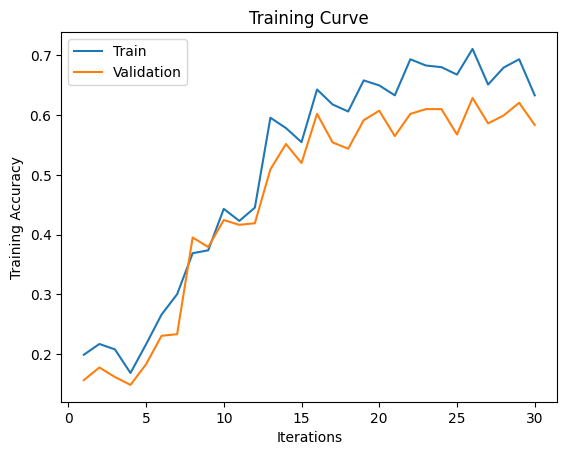

Final Training Accuracy: 0.6331484049930652
Final Validation Accuracy: 0.583554376657825


In [ ]:
##only changing batch_size

use_cuda = True

model_2 = GestRec()

if use_cuda and torch.cuda.is_available():
  model_2.cuda()

  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#proper model

train(model_2, train_dataset, batch_size = 128)

In [ ]:
class GestRec_mod2(nn.Module):
    def __init__(self):
        super(GestRec_mod2, self).__init__()
        self.name = "GestRec_mod2"
        self.conv1 = nn.Conv2d(3, 10, 5, stride = 2, padding = 1) #in channels, #out channels, #kernal size
        self.pool = nn.MaxPool2d(2, 2) #kernal size, stride
        self.conv2 = nn.Conv2d(10, 20, 7, stride = 2, padding = 1)
        self.fc1 = nn.Linear(20 * 13 * 13, 50) #input size, output size
        self.fc2 = nn.Linear(50, 9) #input size, output size

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 20 * 13 * 13)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

model_3 = GestRec_mod2()

CUDA is available!  Training on GPU ...
Epoch 1: Train accuracy: 0.11719833564493759 |Validation accuracy: 0.09814323607427056 
Epoch 2: Train accuracy: 0.12690707350901526 |Validation accuracy: 0.1246684350132626 
Epoch 3: Train accuracy: 0.11927877947295423 |Validation accuracy: 0.10344827586206896 
Epoch 4: Train accuracy: 0.1393897364771151 |Validation accuracy: 0.10610079575596817 
Epoch 5: Train accuracy: 0.21220527045769763 |Validation accuracy: 0.1830238726790451 
Epoch 6: Train accuracy: 0.12343966712898752 |Validation accuracy: 0.13527851458885942 
Epoch 7: Train accuracy: 0.21151178918169208 |Validation accuracy: 0.20689655172413793 
Epoch 8: Train accuracy: 0.2274618585298197 |Validation accuracy: 0.20954907161803712 
Epoch 9: Train accuracy: 0.21359223300970873 |Validation accuracy: 0.1830238726790451 
Epoch 10: Train accuracy: 0.32524271844660196 |Validation accuracy: 0.35013262599469497 
Epoch 11: Train accuracy: 0.3210818307905687 |Validation accuracy: 0.331564986737400

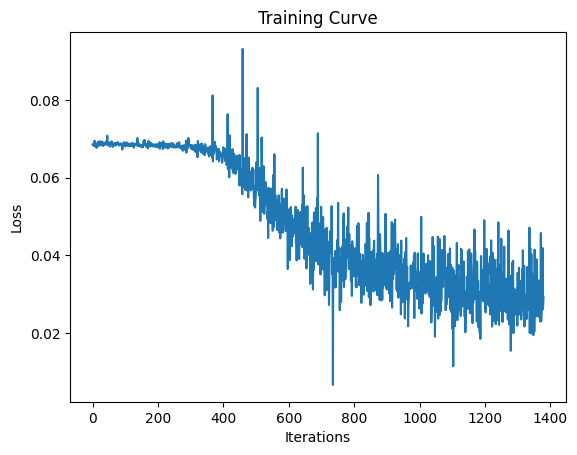

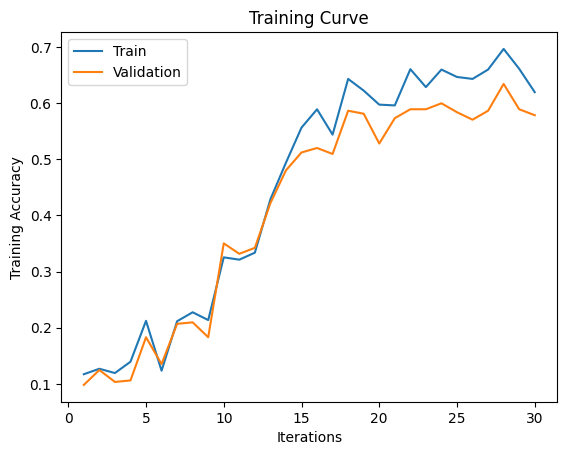

Final Training Accuracy: 0.6192787794729542
Final Validation Accuracy: 0.5782493368700266


In [ ]:
#changing stride and paading, and hidden layers

use_cuda = True

model_3 = GestRec_mod2()

if use_cuda and torch.cuda.is_available():
  model_3.cuda()

  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#proper model

train(model_3, train_dataset, batch_size = 32)

### Part (c) - 2 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

In [ ]:
#I chose the original model with no modifications to
#network architechture, batch_size, and other parameters.
#Because it provides the best validation accuracy among
#all four testing hyperparameter sets. Also, it does not
#show any overfitting.

### Part (d) - 2 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [ ]:
def get_test_accuracy(model, data, batch_size):

    data = test_dataset

    correct = 0
    total = 0

    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        #############################################

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
accuracy = get_test_accuracy(model, test_dataset, 64)
print('The test accuracy on the best model is {:.2f} %'.format(accuracy * 100))

The test accuracy on the best model is 63.40 %


### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 81.5MB/s]


The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [ ]:

# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

#folders
path = '/content/gdrive/MyDrive/Colab Notebooks/APS360 LAB/lab3/Alex_features'

def get_alex_feature(dataset, datatype):
  loader = torch.utils.data.DataLoader(dataset,
                                       batch_size=1,
                                       shuffle=True)
  n = 0
  folder = path + '/' + datatype + '/'

  for imgs, labels in iter(loader):
    features = alexnet.features(imgs)
    features_tensor = torch.from_numpy(features.detach().numpy())
    torch.save(features_tensor.squeeze(0),
              folder + '/' + str(classes[labels]) +'/'
              + str(classes[labels]) +'_'+ str(n)
               + '.tensor')
    n += 1

In [ ]:
get_alex_feature(train_dataset, 'train')
get_alex_feature(val_dataset, 'val')
get_alex_feature(test_dataset, 'test')

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [ ]:
# features = ... load precomputed alexnet.features(img) ...
output = model(features)
prob = F.softmax(output)

In [ ]:
class trans_GestRec(nn.Module):
  def __init__(self):
        super(trans_GestRec, self).__init__()
        self.name = "trans_GestRec"
        self.conv1 = nn.Conv2d(256, 128, 5, padding = 1) #in channels, #out channels, #kernal size
        self.pool = nn.MaxPool2d(2, 2) #kernal size, stride
        self.fc1 = nn.Linear(128 * 2 * 2, 32) #input size, output size
        self.fc2 = nn.Linear(32, 9) #input size, output size

  def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 128 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

transfer_model = trans_GestRec()

**Answer: I chose an CNN model with 1 convolutional layer, 1 pooling layer,
and 2 fully-connected layers. The reason why I reduce the number of convolutional filters is that, the model is already pretrained, so by reducing the filters, the training with take less time but still having high accuracy. The input channels are acquired from the pretrained features, which have 256*6*6 dimensions. The hidden layer, I kept at 32 because it seems to be a good fit for the fully-connected layers. Max pooling is used for reducing feature map dimension. ReLu activation functions are used for model learning extracting non-linearity from training data.**

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [ ]:
alex_train_folder = "/content/gdrive/MyDrive/Colab Notebooks/APS360 LAB/lab3/Alex_features/train"
alex_val_folder = "/content/gdrive/MyDrive/Colab Notebooks/APS360 LAB/lab3/Alex_features/val"
alex_test_folder = "/content/gdrive/MyDrive/Colab Notebooks/APS360 LAB/lab3/Alex_features/test"

In [ ]:
alex_train_data = torchvision.datasets.DatasetFolder(alex_train_folder, loader=torch.load, extensions=('.tensor'))
alex_val_data = torchvision.datasets.DatasetFolder(alex_val_folder, loader=torch.load, extensions=('.tensor'))
alex_test_data = torchvision.datasets.DatasetFolder(alex_test_folder, loader=torch.load, extensions=('.tensor'))

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                  epoch)
    return path

def get_accuracy_trans(model, batch_size, train=False):
    if train:
        data = alex_train_data
    else:
        data = alex_val_data

    correct = 0
    total = 0

    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        #############################################

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train(model, train_data, batch_size=64, learning_rate =0.001, num_epochs=30):
    torch.manual_seed(1000)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    start_time = time.time()
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
          # Loop over each batch of images and labels
          #############################################
          # To Enable GPU Usage
          if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

          #############################################

          out = model(imgs)             # forward pass
          loss = criterion(out, labels) # compute the total loss
          loss.backward()               # backward pass (compute parameter updates)
          optimizer.step()              # make the updates for each parameter
          optimizer.zero_grad()         # a clean-up step for PyTorch

          # save the current training information
          iters.append(n)
          losses.append(float(loss) / batch_size)             # compute *average* loss
          n += 1

          # Save the current model (checkpoint) to a file
          model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
          torch.save(model.state_dict(), model_path)

        train_acc.append(get_accuracy_trans(model, batch_size, train=True))   # compute training accuracy
        val_acc.append(get_accuracy_trans(model, batch_size, train=False))    #compute validation accuracy
        print(("Epoch {}: Train accuracy: {} |" +
                "Validation accuracy: {} ").format(
              epoch +1,
              train_acc[epoch],
              val_acc[epoch]))

    print("Finish Training")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(range(1,num_epochs+1), train_acc, label="Train")
    plt.plot(range(1,num_epochs+1), val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

CUDA is not available.  Training on CPU ...
Epoch 1: Train accuracy: 0.29680998613037446 |Validation accuracy: 0.27851458885941643 
Epoch 2: Train accuracy: 0.5180305131761442 |Validation accuracy: 0.5172413793103449 
Epoch 3: Train accuracy: 0.7565880721220527 |Validation accuracy: 0.7453580901856764 
Epoch 4: Train accuracy: 0.7801664355062413 |Validation accuracy: 0.7453580901856764 
Epoch 5: Train accuracy: 0.8564493758668515 |Validation accuracy: 0.8143236074270557 
Epoch 6: Train accuracy: 0.8613037447988904 |Validation accuracy: 0.8063660477453581 
Epoch 7: Train accuracy: 0.8723994452149791 |Validation accuracy: 0.8328912466843501 
Epoch 8: Train accuracy: 0.9036061026352289 |Validation accuracy: 0.8514588859416445 
Epoch 9: Train accuracy: 0.9153952843273232 |Validation accuracy: 0.8567639257294429 
Epoch 10: Train accuracy: 0.9070735090152566 |Validation accuracy: 0.8567639257294429 
Epoch 11: Train accuracy: 0.9251040221914009 |Validation accuracy: 0.8673740053050398 
Epoch 

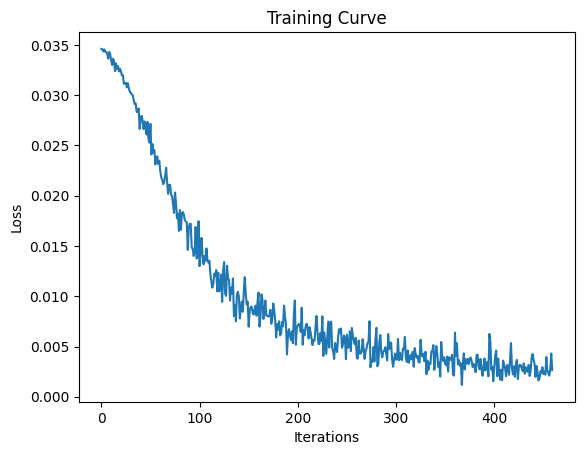

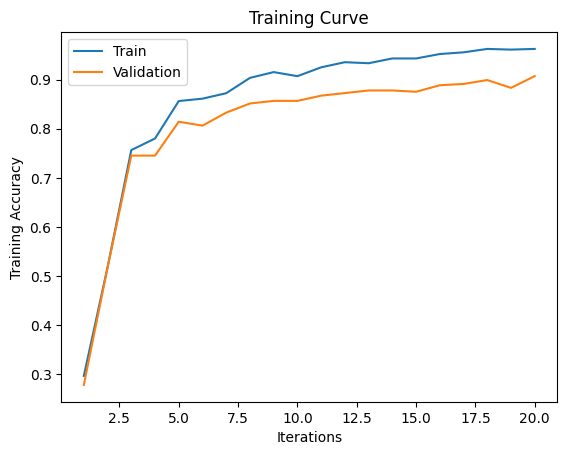

Final Training Accuracy: 0.9625520110957004
Final Validation Accuracy: 0.9071618037135278


In [ ]:
use_cuda = True

trans_model = trans_GestRec()

if use_cuda and torch.cuda.is_available():
  trans_model.cuda()

  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#proper model

train(trans_model, alex_train_data, batch_size = 64, num_epochs = 20)

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [ ]:
def get_test_accuracy_trans(model, dataset, batch_size):

    data = dataset

    correct = 0
    total = 0

    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        #############################################

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
alex_accuracy = get_test_accuracy_trans(trans_model, alex_test_data, 64)
print('The test accuracy on the transfer learning model is {:.2f} %'.format(alex_accuracy * 100))
print('While the test accuracy on the best model from part3 is only {:.2f} %'.format(accuracy * 100))

#the test accuracy is much more higher than
#the model accuracy we got from part3 (64.30%) before
#we applied transfer learning.

#Transfer learning helps us reduce model
#training time and increases model accuracy.
#The new model requires less layers, less epochs to train,
#which makes the training process more efficient.

The test accuracy on the transfer learning model is 91.51 %


### 5. Additional Testing [5 pt]
As a final step in testing we will be revisiting the sample images that you had collected and submitted at the start of this lab. These sample images should be untouched and will be used to demonstrate how well your model works at identifying your hand guestures.

Using the best transfer learning model developed in Part 4. Report the test accuracy on your sample images and how it compares to the test accuracy obtained in Part 4(d)? How well did your model do for the different hand guestures? Provide an explanation for why you think your model performed the way it did?

In [ ]:
#I will explain what I would do:

#I will use similar method in part 4a to
#transfer my overfit_dataset to AlexNet features
#Then I will use the code below to get the accuracy
#of the small sample data.

sample_accurracy = get_test_accuracy(trans_model,
                                     overfit_dataset, #this should be
                                                      #AlexNet features
                                     batch_size = 23)

#due to an unexpected accident, the original file that
#I was working on crashed, so I need to retrieve an older
#version of the file and start working from this document.
#However, for this question, I need re-run most of the code
#above from part 4, which was very time consuming, so I decided
#to write down my thoughts in words:
  #I believe that accuracy we get of our transfer learning
  #on this sample set will be high. Because our model is trained
  #using transfer learning method, in which it learned high-level
  #features using the AlexNet baseline model. So upon making
  #prediction on images it has never seen before, it will
  #perform well. Compare to the accuracy we obtained from part4,
  #I believe the accuracy will be similar, since the model
  #has never seen the test dataset before as well.